Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


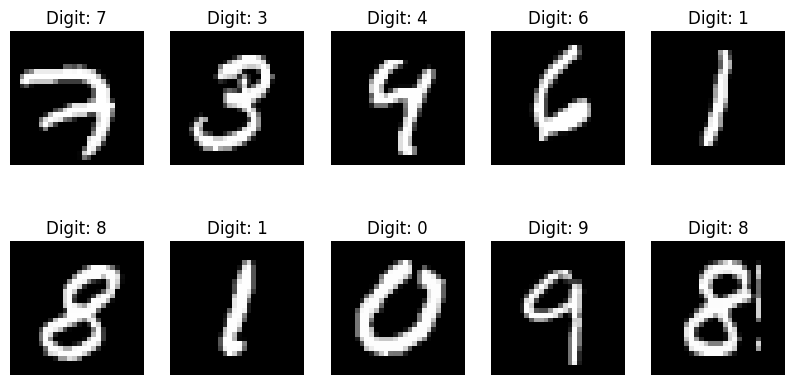

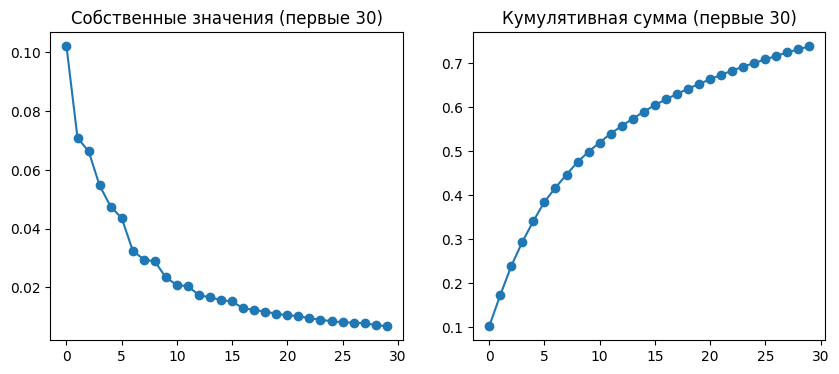

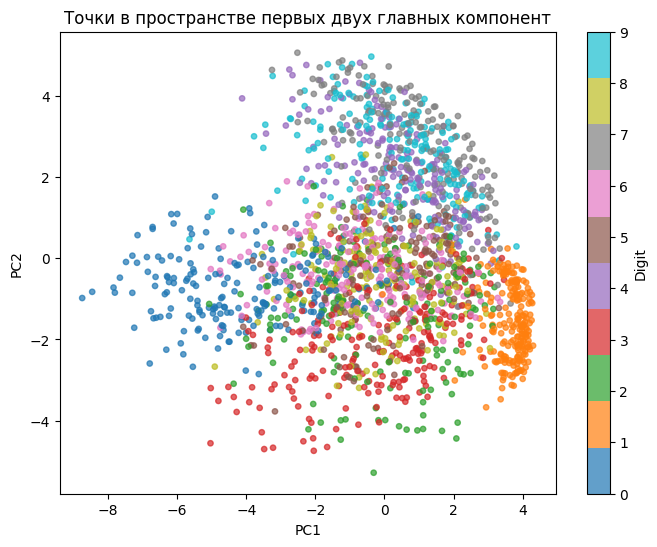

[k=5, n_comp=No PCA] Accuracy = 0.9270
[k=3, n_comp=10] Accuracy = 0.8830
[k=5, n_comp=10] Accuracy = 0.8885
[k=7, n_comp=10] Accuracy = 0.8885
[k=3, n_comp=20] Accuracy = 0.9295
[k=5, n_comp=20] Accuracy = 0.9315
[k=7, n_comp=20] Accuracy = 0.9275
[k=3, n_comp=50] Accuracy = 0.9360
[k=5, n_comp=50] Accuracy = 0.9375
[k=7, n_comp=50] Accuracy = 0.9310

Вывод:
1. PCA уменьшает размерность и сохраняет значимую часть информации.
2. Первые 2 компоненты дают визуализацию, но классы частично пересекаются.
3. При PCA с 20–50 компонентами kNN работает быстрее и точнее, чем без PCA.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from sklearn.metrics import accuracy_score
from collections import Counter

class my_PCA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
        self.components = Vt[:self.n_components]

    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components.T)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


class my_kNN:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = []
        for x in X:
            distances = np.linalg.norm(self.X_train - x, axis=1)
            k_idx = np.argsort(distances)[:self.n_neighbors]
            k_labels = self.y_train[k_idx].ravel()
            most_common = Counter(k_labels).most_common(1)[0][0]
            y_pred.append(most_common)
        return np.array(y_pred)



def plot_examples(X, y):
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[i].reshape(28, 28), cmap="gray")
        ax.set_title(f"Digit: {y[i]}")
        ax.axis("off")
    plt.show()


def pca_analysis(X_train):
    X_flat = X_train.reshape(X_train.shape[0], -1)  #разворачиваем картинки
    pca = my_PCA(n_components=50)
    pca.fit(X_flat)

    _, S, _ = np.linalg.svd(X_flat - np.mean(X_flat, axis=0), full_matrices=False)
    explained_variance = (S**2) / np.sum(S**2)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(explained_variance[:30], marker="o")
    plt.title("Собственные значения (первые 30)")

    plt.subplot(1, 2, 2)
    plt.plot(np.cumsum(explained_variance[:30]), marker="o")
    plt.title("Кумулятивная сумма (первые 30)")
    plt.show()


def plot_pca_scatter(X, y, sample_size=2000):
    X_small = X[:sample_size]
    y_small = y[:sample_size]

    X_flat = X_small.reshape(X_small.shape[0], -1)  #разворачиваем картинки

    pca = my_PCA(n_components=2)
    X_pca = pca.fit_transform(X_flat)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_small, cmap="tab10", s=15, alpha=0.7)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Точки в пространстве первых двух главных компонент")
    plt.colorbar(scatter, ticks=range(10), label="Digit")
    plt.show()


#Проверка kNN
def run_knn(X_train, X_test, y_train, y_test, use_pca=False, n_components=50, k=5):
    if use_pca:
      X_train_flat = X_train.reshape(X_train.shape[0], -1)
      X_test_flat = X_test.reshape(X_test.shape[0], -1)

      pca = my_PCA(n_components=n_components)
      X_train = pca.fit_transform(X_train_flat)
      X_test = pca.transform(X_test_flat)
    else:
      X_train = X_train.reshape(X_train.shape[0], -1)
      X_test = X_test.reshape(X_test.shape[0], -1)


    knn = my_kNN(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"[k={k}, n_comp={n_components if use_pca else 'No PCA'}] Accuracy = {acc:.4f}")
    return acc


if __name__ == "__main__":
    train, validation, test = load_mnist()
    X_train, y_train = train
    X_test, y_test = test

    #нормализация
    X_train = X_train.astype(np.float32) / 255.0
    X_test = X_test.astype(np.float32) / 255.0

    X_train, y_train = X_train[:10000], y_train[:10000]
    X_test, y_test = X_test[:2000], y_test[:2000]

    y_train = y_train.ravel()
    y_test = y_test.ravel()

    plot_examples(X_train, y_train)

    pca_analysis(X_train)

    plot_pca_scatter(X_train, y_train)

    run_knn(X_train, X_test, y_train, y_test, use_pca=False, k=5)

    for n_comp in [10, 20, 50]:
        for k in [3, 5, 7]:
            run_knn(X_train, X_test, y_train, y_test, use_pca=True, n_components=n_comp, k=k)

    print("\nВывод:")
    print("1. PCA уменьшает размерность и сохраняет значимую часть информации.")
    print("2. Первые 2 компоненты дают визуализацию, но классы частично пересекаются.")
    print("3. При PCA с 20–50 компонентами kNN работает быстрее и точнее, чем без PCA.")